# Prepare Compass inputs, random groups within cell states

Try to capture biological and technical variation by partitioning within replicates divided by age bin, cell/nuclei, cell state

## Setup

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import sctk

/home/jovyan/my-conda-envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 0            # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'Reds', figsize = (5, 5),dpi_save=300)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
# Perform pseudobulk on sc data

import scipy.sparse as sp

def pseudo_bulk(
        adata, groupby, use_rep='X', highly_variable=False, FUN=np.mean):
    """Make pseudo bulk data from grouped sc data
    """
    if adata.obs[groupby].dtype.name == 'category':
        group_attr = adata.obs[groupby].values
        groups = adata.obs[groupby].cat.categories.values
    else:
        group_attr = adata.obs[groupby].astype(str).values
        groups = np.unique(group_attr)
    n_level = len(groups)
    if highly_variable:
        if isinstance(highly_variable, (list, tuple)):
            if use_rep == 'raw':
                k_hv = adata.raw.var_names.isin(highly_variable)
            else:
                k_hv = adata.var_names.isin(highly_variable)
        else:
            k_hv = adata.var['highly_variable'].values
    if use_rep == 'X':
        x = adata.X
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep == 'raw':
        x = adata.raw.X
        features = adata.raw.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.layers.keys():
        x = adata.layers[use_rep]
        features = adata.var_names.values
        if highly_variable:
            x = x[:, k_hv]
            features = features[k_hv]
    elif use_rep in adata.obsm.keys():
        x = adata.obsm[use_rep]
        features = np.arange(x.shape[1])
    elif (isinstance(use_rep, np.ndarray) and
            use_rep.shape[0] == adata.shape[0]):
        x = use_rep
        features = np.arange(x.shape[1])
    else:
        raise KeyError(f'{use_rep} invalid.')
    summarised = np.zeros((n_level, x.shape[1]))
    for i, grp in enumerate(groups):
        k_grp = group_attr == grp
        if sp.issparse(x):
            summarised[i] = FUN(x[k_grp, :], axis=0)
        else:
            summarised[i] = FUN(x[k_grp, :], axis=0, keepdims=True)
    return pd.DataFrame(summarised.T, columns=groups, index=features)

def random_partition(
    adata,
    partition_size,
    groupby=None,
    method="random_even",
    key_added="partition_labels",
    random_state=0,
):
    np.random.seed(random_state)
    if groupby:
        if groupby not in adata.obs.columns:
            raise KeyError(f"{groupby} is not a valid obs annotation.")
        groups = adata.obs[groupby].unique()
        label_df = adata.obs[[groupby]].astype(str).rename(columns={groupby: key_added})
        for grp in groups:
            k = adata.obs[groupby] == grp
            grp_size = sum(k)
            n_partition = max(np.round(grp_size / partition_size).astype(int), 1)
            if method == "random":
                part_idx = np.random.randint(low=0, high=n_partition, size=grp_size)
            elif method == "random_even":
                part_sizes = list(map(len, np.array_split(np.arange(grp_size), n_partition)))
                part_idx = np.repeat(np.arange(n_partition), part_sizes)
                np.random.shuffle(part_idx)
            else:
                raise NotImplementedError(method)
            label_df.loc[k, key_added] = [f"{grp},{i}" for i in part_idx]
        adata.obs[key_added] = label_df[key_added]
    else:
        n_partition = max(np.round(adata.n_obs / partition_size).astype(int), 1)
        if method == "random":
            part_idx = np.random.randint(low=0, high=n_partition, size=adata.n_obs)
        elif method == "random_even":
            part_sizes = list(map(len, np.array_split(np.arange(adata.n_obs), n_partition)))
            part_idx = np.repeat(np.arange(n_partition), part_sizes)
            np.random.shuffle(part_idx)
        else:
            raise NotImplementedError(method)
        adata.obs[key_added] = part_idx.astype(str)

## Import suspension data

In [5]:
adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/final_annotation/FetalHearts13Aug_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 176050 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region_finest', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key', '_scvi_batch', '_scvi_labels', 'annotation_Semih', 'leiden_scVI', 'cell_type_pre', 'pth', 'ito', 'FACSgate', 'leiden_scVI_0.05', 'leiden_scVI_0.01', 'leiden_scVI_0.1', 'leiden_scVI_0.15', 'leiden_scVI_0.2', 'leiden_scVI_0.25', 'leiden_scVI_0.3', 'leiden_scVI_0.35', 'leiden_scVI_0.4', 'cell_type', 'coarse_grain', 'fine_grain', 'region', 'sex', 'age', 'cycling', 'S_score', 'G2M_sco

In [7]:
# Recover log-normed data for all genes to adata.X (allows Compass to calculate reactions across all genes, not just HVG-subsetted!)
print(adata.shape)
#adata=adata.raw.to_adata()
#print(adata.shape)

(176050, 36601)


In [8]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['ENSG00000243485', 'ENSG00000237613'], dtype='object', name='id')
[1. 1. 5. 5. 8.]


In [9]:
# data needs to be log normed
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
# change var names to gene symbols
genename_column='gene_name_multiome-1'
adata.var['gene_id']=adata.var_names
adata.var.set_index(genename_column, inplace=True)
adata.var_names=adata.var_names.astype('str')
adata.var_names_make_unique()

In [12]:
# Check var_names are gene symbols, and the data is log-normed
print(adata.var.index[:2])
print(adata.X.data[:5])

Index(['MIR1302-2HG', 'FAM138A'], dtype='object', name='gene_name_multiome-1')
[0.09802544 0.09802544 0.41538528 0.41538528 0.6009918 ]


# Subset trab/comp CMs

In [13]:
adata.obs['fine_grain'].value_counts()

GreatVesselAdventitialFibroblasts        18605
MyocardialInterstitialFibroblasts        15073
VentricularCardiomyocytesCompact         13740
GreatVesselProgenitors                   13175
VentricularCardiomyocytesPRRX1pos        11627
VentricularCardiomyocytesCycling         11297
MacrophagesLYVE1pos                       8864
GreatVesselSmoothMuscleCells              7870
EndocardialCells                          7418
ValveInterstitialCells                    7222
VentricularCardiomyocytesTrabeculated     6936
AtrialCardiomyocytesLeft                  6304
AtrialCardiomyocytesRight                 5452
Cardiofibromyocytes                       5278
CoronaryEndothelialCellsCapillary         4834
CoronaryVesselAdventitialFibroblasts      2683
CoronaryPericytes                         2077
SatelliteGlialCells                       2008
Myofibroblasts                            1826
MacrophagesCX3CR1pos                      1609
VentricularConductionSystemDistal         1568
InnateLymphoi

In [14]:
print(adata.shape)
adata=adata[adata.obs['fine_grain'].isin(['VentricularCardiomyocytesTrabeculated','VentricularCardiomyocytesCompact'])]
print(adata.shape)

(176050, 36601)
(20676, 36601)


# Prepare data for Compass
"The input gene expression matrix can be either a tab-delimited text file (tsv) or a matrix market format (mtx) containing gene expression estimates (CPM, TPM, or similar scaled units) with one row per gene, one column per sample."

## .mtx method (gene x sampleID, 3 files)
This allows you to specify the 'samples', so rather than calculating reactions in all single cells individually (or micro-pooled) we can make our own "samples" (pseudobulking them)

Need to ensure the samples are representative of the sample. Here we use a new batch key of cell state and the previous batch key  to form the 'samples'
This requires 3 files, to inputted thus ```--data expression.mtx genes.tsv sample_names.tsv```

Another option would be to use Milo or Metacell to make small samples, below I am going to just use the batch key to make samples within each cell state.

In [15]:
age_to_agebins = {
    '15W1D':'T2',
    '10W4D':'lateT1',
    '7W4D':'earlyT1',
    '9W4D':'lateT1',
    '9W1D':'lateT1',
    '8W1D':'earlyT1',
    '9W6D':'lateT1',
    '8W2D':'earlyT1',
    '11W3D':'lateT1',
    '12W5D':'lateT1',
    '9W3D':'lateT1',
    '8W5D':'earlyT1',
    '11W2D':'lateT1',
}
adata.obs['age_binned'] = (
    adata.obs['age']
    .map(age_to_agebins)
    .astype('category')
)

/tmp/ipykernel_15008/991080021.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['age_binned'] = (


<AxesSubplot:>

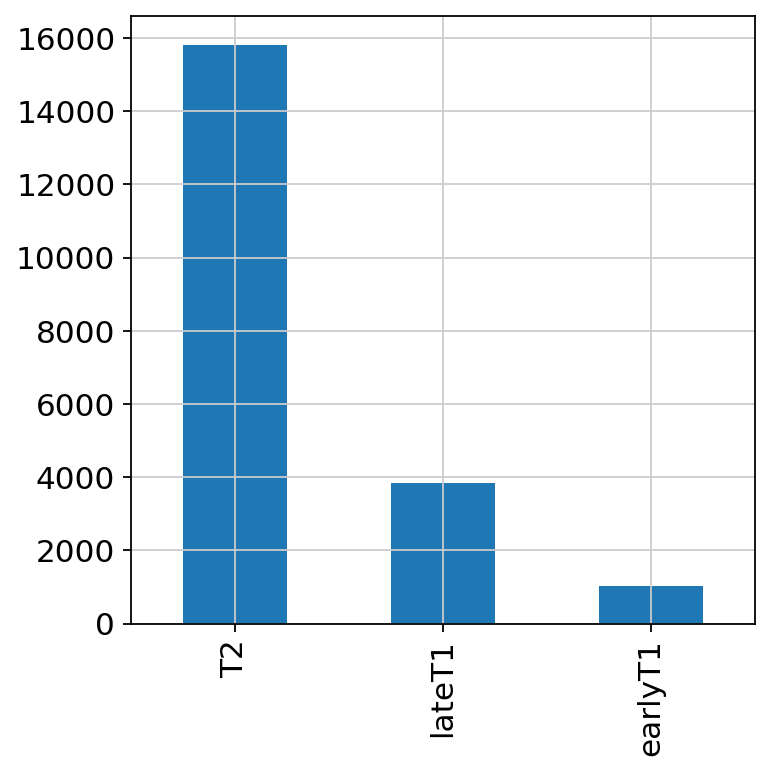

In [16]:
adata.obs['age_binned'].value_counts().plot.bar()
#adata.obs['compass_label'].value_counts()#.hist(bins = 200)

In [17]:
# make a label combining cell state, age, and cell vs nuclei
adata.obs['compass_label']=adata.obs['fine_grain'].astype(str)+'_'+adata.obs['age_binned'].astype(str)+'_'+adata.obs['cell_or_nuclei'].astype(str)

<AxesSubplot:>

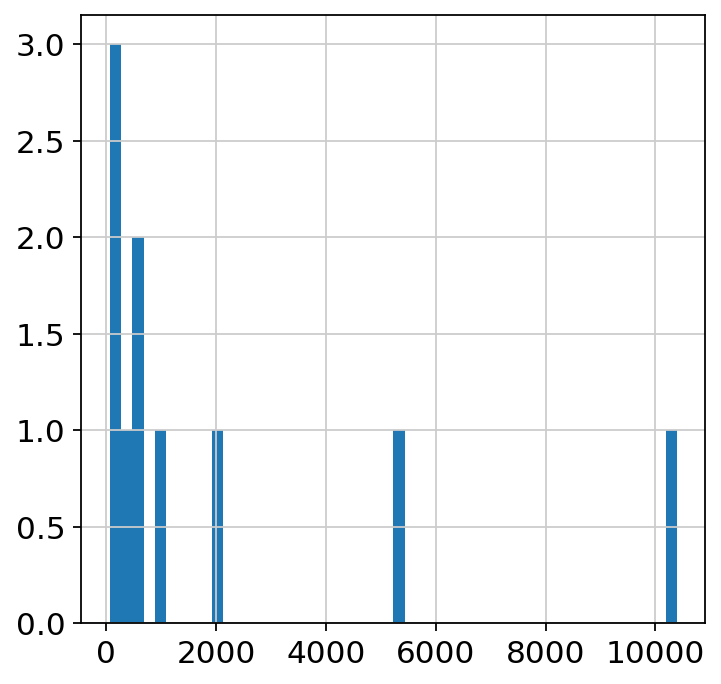

In [18]:
adata.obs['compass_label'].value_counts().hist(bins = 50)

In [19]:
# Make random partition using sctk
random_partition(adata, partition_size=10, groupby="compass_label", key_added="partition_10")

In [20]:
#find out how many groups were made during partitioning
len(adata.obs['partition_10'].unique())

2065

<AxesSubplot:>

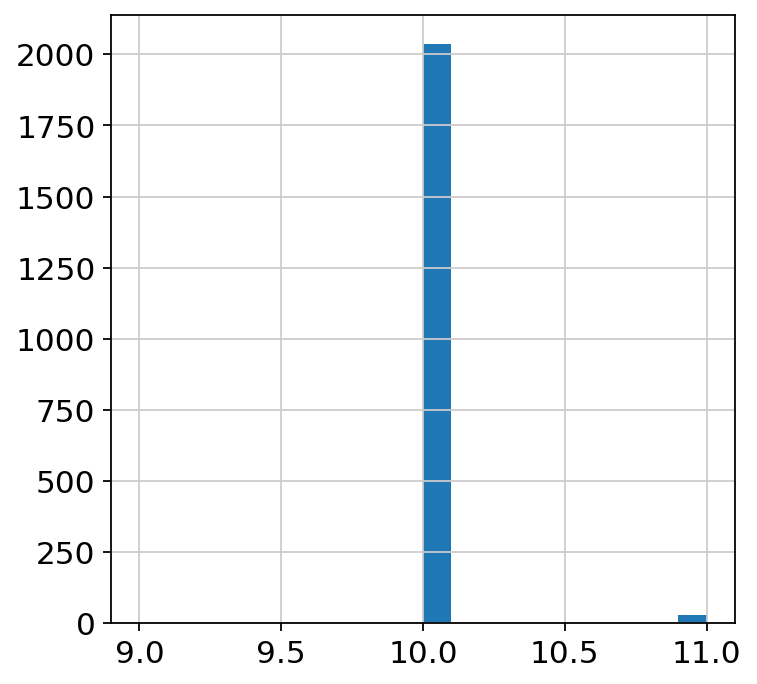

In [21]:
tmp=adata.obs['partition_10'].value_counts()
tmp[tmp<19].hist(bins = 20)

In [22]:
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,sangerID,combinedID,donor,donor_type,region_finest,facility,cell_or_nuclei,...,age,cycling,S_score,G2M_score,phase,stress_score,hb1_score,age_binned,compass_label,partition_10
barcode,,,,,,,,,,,,,,,,,,,,,
BHF_F_Hea10402917_CACCACTAGAGTGAGA-1,2.600170,0.999989,8616.544922,BHF_F_Hea10402917,na,C86,na,Heart,Sanger,Cell,...,12W5D,No,-0.029281,-0.075899,G1,-0.012796,-0.177667,lateT1,VentricularCardiomyocytesCompact_lateT1_Cell,"VentricularCardiomyocytesCompact_lateT1_Cell,101"
BHF_F_Hea10402917_TCTTTCCTCTGGTGTA-1,2.481375,0.999992,8874.579102,BHF_F_Hea10402917,na,C86,na,Heart,Sanger,Cell,...,12W5D,No,-0.015760,-0.130530,G1,-0.192063,-0.178246,lateT1,VentricularCardiomyocytesTrabeculated_lateT1_Cell,VentricularCardiomyocytesTrabeculated_lateT1_C...
BHF_F_Hea10402917_CTTCTCTCAAAGTCAA-1,1.600878,0.999969,6814.155273,BHF_F_Hea10402917,na,C86,na,Heart,Sanger,Cell,...,12W5D,Yes,-0.051331,-0.021699,G1,-0.005175,-0.122077,lateT1,VentricularCardiomyocytesTrabeculated_lateT1_Cell,VentricularCardiomyocytesTrabeculated_lateT1_C...
BHF_F_Hea10402917_TACGGGCTCTGTCAAG-1,1.649440,0.999959,6893.636719,BHF_F_Hea10402917,na,C86,na,Heart,Sanger,Cell,...,12W5D,No,-0.035935,-0.064939,G1,-0.138496,-0.102717,lateT1,VentricularCardiomyocytesCompact_lateT1_Cell,"VentricularCardiomyocytesCompact_lateT1_Cell,97"
BHF_F_Hea10402917_CCAGCGATCAATAAGG-1,1.611594,0.999956,6582.592285,BHF_F_Hea10402917,na,C86,na,Heart,Sanger,Cell,...,12W5D,No,-0.049865,-0.049819,G1,-0.048685,-0.122676,lateT1,VentricularCardiomyocytesCompact_lateT1_Cell,"VentricularCardiomyocytesCompact_lateT1_Cell,184"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BHF_F_Hea11933675_BHF_F_Hea11596628_ATACCTGCAGGCATCT-1,1.276911,0.999999,7000.433105,BHF_F_Hea11933675,BHF_F_Hea11933675_BHF_F_Hea11596628,C98,na,Heart,Sanger,Nuclei,...,9W1D,Yes,-0.102170,-0.242595,G1,-0.314754,-0.048717,lateT1,VentricularCardiomyocytesTrabeculated_lateT1_N...,VentricularCardiomyocytesTrabeculated_lateT1_N...
BHF_F_Hea11933675_BHF_F_Hea11596628_TCAGGTTAGTTGGGCC-1,1.166417,0.999995,7045.555176,BHF_F_Hea11933675,BHF_F_Hea11933675_BHF_F_Hea11596628,C98,na,Heart,Sanger,Nuclei,...,9W1D,No,-0.053006,-0.186767,G1,-0.519473,0.059844,lateT1,VentricularCardiomyocytesCompact_lateT1_Nuclei,"VentricularCardiomyocytesCompact_lateT1_Nuclei,20"
BHF_F_Hea11933675_BHF_F_Hea11596628_CTATTGAAGTAACAGG-1,1.125384,0.999980,5426.603027,BHF_F_Hea11933675,BHF_F_Hea11933675_BHF_F_Hea11596628,C98,na,Heart,Sanger,Nuclei,...,9W1D,No,-0.011971,-0.144595,G1,-0.512476,-0.257420,lateT1,VentricularCardiomyocytesTrabeculated_lateT1_N...,VentricularCardiomyocytesTrabeculated_lateT1_N...


In [23]:
# Pseudobulk use Ni's psudobulk function
pseudo_bulk = pseudo_bulk(adata,
                         groupby='partition_10')

In [25]:
print(pseudo_bulk.shape)
pseudo_bulk.head(3)

(36601, 2065)


,"VentricularCardiomyocytesCompact_T2_Nuclei,0","VentricularCardiomyocytesCompact_T2_Nuclei,1","VentricularCardiomyocytesCompact_T2_Nuclei,10","VentricularCardiomyocytesCompact_T2_Nuclei,100","VentricularCardiomyocytesCompact_T2_Nuclei,1000","VentricularCardiomyocytesCompact_T2_Nuclei,1001","VentricularCardiomyocytesCompact_T2_Nuclei,1002","VentricularCardiomyocytesCompact_T2_Nuclei,1003","VentricularCardiomyocytesCompact_T2_Nuclei,1004","VentricularCardiomyocytesCompact_T2_Nuclei,1005",...,"VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,27","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,28","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,29","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,3","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,4","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,5","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,6","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,7","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,8","VentricularCardiomyocytesTrabeculated_lateT1_Nuclei,9"
MIR1302-2HG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# make sample_names.tsv
pseudo_bulk.columns.to_frame().to_csv('/nfs/team205/heart/compass/fetal_trabcomp_random10/sample_names.tsv', sep="\t", index=False, header=False)

# make genes.tsv
genes = pseudo_bulk.index.to_list()
genes = pd.DataFrame(genes)
genes.to_csv('/nfs/team205/heart/compass/fetal_trabcomp_random10/genes.tsv', sep="\t", index = False, header=False)

# make expression.mtx
from scipy.io import mmwrite, mmread
from scipy.sparse import csr_matrix

# Count Matrix (log normed, all genes, not HVG subsetted)
sparce_mtx = csr_matrix(pseudo_bulk)
sparce_mtx = sparce_mtx
mmwrite('/nfs/team205/heart/compass/fetal_trabcomp_random10/expression.mtx', sparce_mtx)

# Export cell metadata

In [27]:
# Alter so it includes things you need (a reference e.g. barcode and a cell type e.g. in fine_grain)
adata.obs.to_csv('/nfs/team205/heart/compass/fetal_trabcomp_random10/cell_metadata.csv')

In [31]:
print('ready to bsub')

ready to bsub


# Run Compass

## bsub command

```
bsub \
-G teichlab \
-q basement \
-M100000 \
-R "select[mem>100000] rusage[mem=100000] span[hosts=1]" \
-n 30 \
-J trabcompCM_batch_rand10 \
-o 'log/compass.%J.out' \
-e 'log/compass.%J.err' \
'/software/singularity-v3.6.4/bin/singularity run -B /nfs,/lustre -B ~/COMPASSResources:/usr/local/lib/python3.8/site-packages/compass/Resources /nfs/cellgeni/singularity/images/compass-v0.9.10.2-cplex-v20.10.sif compass --data-mtx /nfs/team205/heart/compass/fetal_trabcomp_random10/expression.mtx /nfs/team205/heart/compass/fetal_trabcomp_random10/genes.tsv /nfs/team205/heart/compass/fetal_trabcomp_random10/sample_names.tsv --species homo_sapiens --precache --calc-metabolites --output-dir /nfs/team205/heart/compass/fetal_trabcomp_random10/out/ --detailed-perf --num-processes 30'
```